In [3]:
#general utility packages
import numpy as np
import matplotlib.pyplot as plt

#nice modules from astropy
import astropy.units as u
import astropy.constants as const

#remind matplotlib how to do 3D plotting
from mpl_toolkits.mplot3d import Axes3D

In [4]:
!pip install PyAstronomy
import PyAstronomy
from PyAstronomy import pyasl

In [5]:
%matplotlib notebook

## Function to Build Ellipse and Sample Positions
Parameters should be in units of au, years, and degrees 
e is the eccentricity of the orbit


omega is longitude of ascending node in degrees


i is inclination in degrees


w is argument is periapse in degrees


num_timestep is the number of data points to build the ellipse


index is the number of the point you want to sample

In [6]:
# I decided to combine the building step and the sampling step because the "build" function would just be the same as the py.asl KE function
def build_and_sample_ellipse(semimajor, period, e, omega, i, w, num_timestep, index):
    ke = pyasl.KeplerEllipse(semimajor, period, e, Omega = omega,i = i,w = w)
    # Build the ellipse
    t = np.linspace(0, period, num_timestep)
    # Make a time axis
    pos = ke.xyzPos(t)
    # Marks data points at each timestep
    return 'x, y, z for point ' + str(index) + ':' + str(pos[index,::])

In [7]:
# Testing the function on the parameters from the example
print(build_and_sample_ellipse(1, 1, 0.05, 0, 90, 0, 200, 50))

x, y, z for point 50:[-1.07777728e-01  6.10535892e-17  9.97080779e-01]


## Function to Create Interactive 2D and 3D Plots of Ellipse

In [19]:
# This function returns the ellipse and timescale to be used for later functions
def build_and_plot_ellipse(semimajor, period, e, omega, i, w, num_timestep):
    ke = pyasl.KeplerEllipse(semimajor, period, e, Omega = omega,i = i,w = w)
    # Build the ellipse
    t = np.linspace(0, period, num_timestep)
    # Make a time axis
    pos = ke.xyzPos(t)
    # Marks data points at each timestep
    plt.figure()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((-1.5,1.5))
    plt.ylim((-1.5,1.5))
    plt.title("Appearance of the orbit on the sky (to Earth observer)")
    plt.plot([0], [0], 'k+', markersize=9)
    plt.plot(pos[::, 0], pos[::, 1], 'bo')
    plt.figure()
    ax = plt.axes(projection='3d')
    ax.set_title("3D Orbit - observer is in the +z direction")
    ax.scatter(0, 0, 0, color='black', marker='+')
    ax.scatter3D(pos[::, 0], pos[::, 1], pos[::, 2], color='blue')
    ax.set_xlim((-1,1))
    ax.set_ylim((-1,1))
    ax.set_zlim((-1,1))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    return [ke,t]

Variables denoted with _1 are calculated values using the sample exoplanet.

<IPython.core.display.Javascript object>


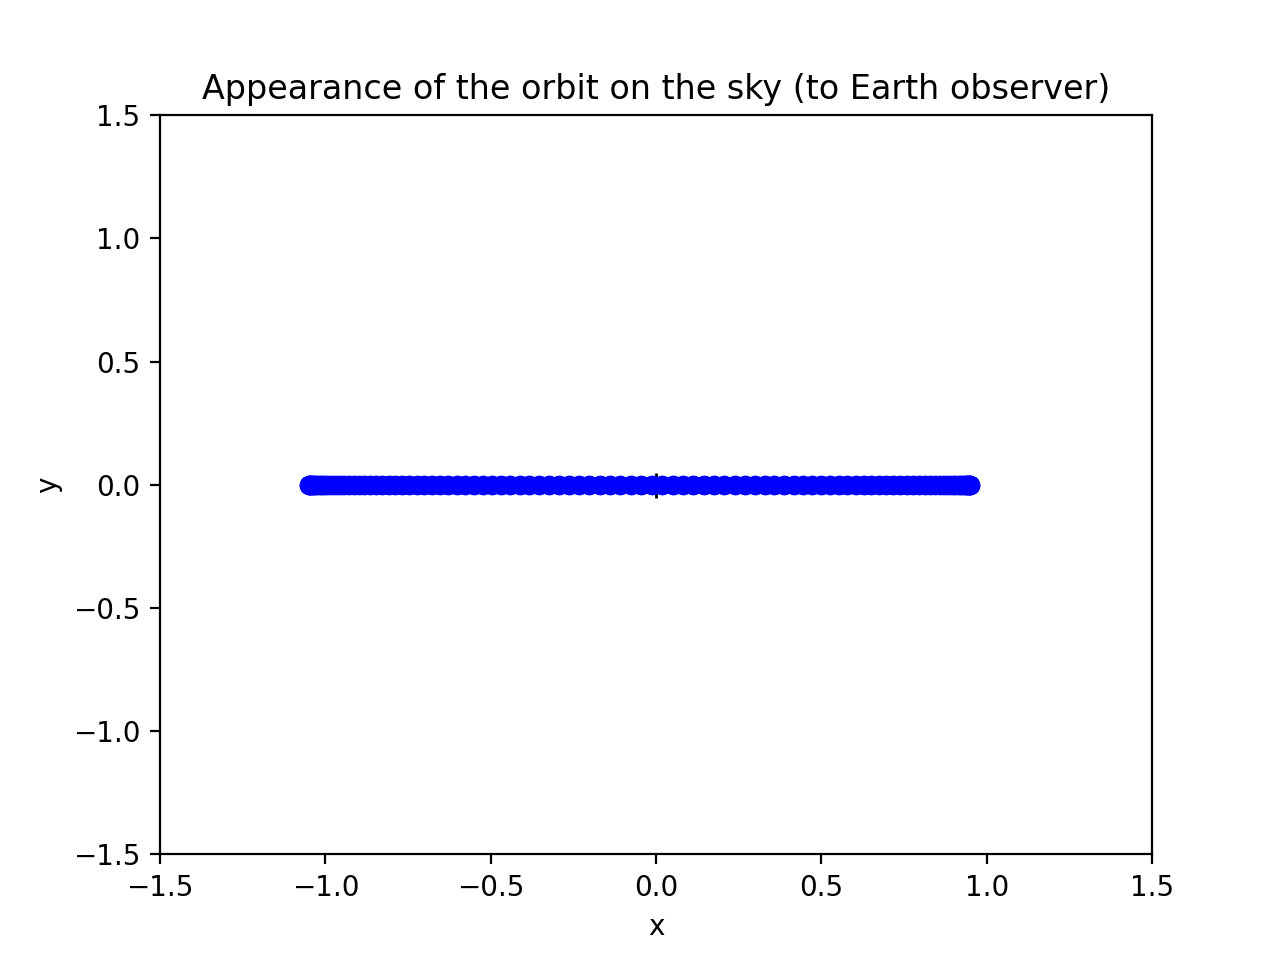

<IPython.core.display.Javascript object>


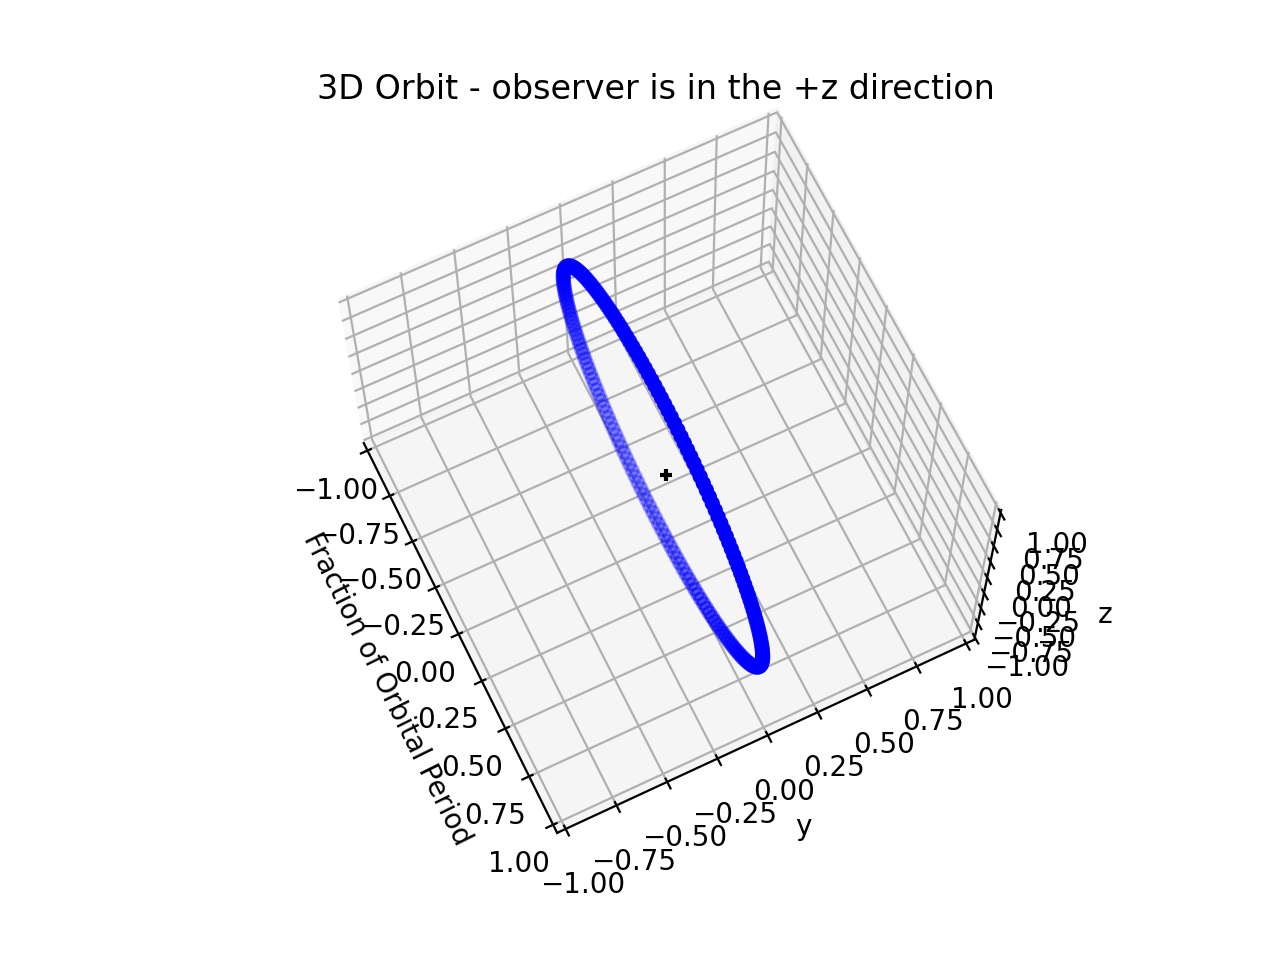

In [61]:
ke_1 = build_and_plot_ellipse(1, 1, 0.05, 0, 90, 0, 200)
plt.show()

## Function to Calculate Drift Rate at Each Position

In [49]:
G = const.G
c = 3 * 10**8
stellar_mass = 1 * u.Msun

In [26]:
def measure_total_acceleration(ke):
    radius = ke[0].radius(ke[1])
    total_acc = G*stellar_mass/ (radius* u.au)**2
    return total_acc.si

In [27]:
acc_array_1 = measure_total_acceleration(ke_1)
print(acc_array_1)

[0.00657073 0.00657035 0.0065692  0.0065673  0.00656463 0.00656122
 0.00655705 0.00655215 0.00654652 0.00654017 0.00653311 0.00652536
 0.00651693 0.00650783 0.00649808 0.00648769 0.00647669 0.0064651
 0.00645293 0.0064402  0.00642694 0.00641316 0.0063989  0.00638416
 0.00636898 0.00635338 0.00633738 0.00632101 0.00630429 0.00628725
 0.0062699  0.00625228 0.00623441 0.00621631 0.00619801 0.00617952
 0.00616089 0.00614212 0.00612324 0.00610427 0.00608524 0.00606616
 0.00604707 0.00602798 0.0060089  0.00598987 0.00597089 0.005952
 0.0059332  0.00591452 0.00589597 0.00587757 0.00585933 0.00584128
 0.00582342 0.00580578 0.00578836 0.00577118 0.00575425 0.00573758
 0.00572119 0.00570509 0.00568929 0.0056738  0.00565862 0.00564378
 0.00562927 0.00561511 0.00560131 0.00558787 0.00557479 0.0055621
 0.00554979 0.00553787 0.00552635 0.00551522 0.00550451 0.00549421
 0.00548432 0.00547486 0.00546582 0.00545722 0.00544904 0.00544131
 0.00543401 0.00542715 0.00542074 0.00541478 0.00540927 0.00540421

## Function to Calculate *Projected* Drift Rate at Each Position

In [53]:
# To get the acceleration in the radial direction of the observer, which is then used to find the drift rate.
def final_drift_rate(acc_array, ke):
    z_acceleration_array = []
    vector_to_earth = [0,0,1]
    for i in range(0, len(acc_array)):
        position_vector = ke[0].xyzPos(ke[1])[i,:]
        radius = ke[0].radius(ke[1])
        # vector from the origin (host star) to the point in the orbit
        z_magnitude = np.dot(vector_to_earth, position_vector) / radius[i]
        # normalized magnitude of the vector in the observer's direction - between -1 and 1
        z_acceleration_array.append((z_magnitude * acc_array[i]).value/c)
        # I removed the units from c in favor of adding in the per second at the end as arrays don't do too well with units
    return z_acceleration_array /u.s

In [55]:
final_drift_rate_1 = final_drift_rate(acc_array_1, ke_1)
print(final_drift_rate(acc_array_1, ke_1))

[ 0.00000000e+00  7.65079115e-13  1.52886907e-12  2.29008509e-12
  3.04745119e-12  3.79970447e-12  4.54559930e-12  5.28391151e-12
  6.01344227e-12  6.73302195e-12  7.44151369e-12  8.13781683e-12
  8.82087002e-12  9.48965421e-12  1.01431953e-11  1.07805663e-11
  1.14008900e-11  1.20033400e-11  1.25871430e-11  1.31515795e-11
  1.36959850e-11  1.42197506e-11  1.47223232e-11  1.52032061e-11
  1.56619581e-11  1.60981940e-11  1.65115830e-11  1.69018487e-11
  1.72687673e-11  1.76121668e-11  1.79319256e-11  1.82279705e-11
  1.85002753e-11  1.87488589e-11  1.89737832e-11  1.91751514e-11
  1.93531053e-11  1.95078237e-11  1.96395202e-11  1.97484403e-11
  1.98348600e-11  1.98990832e-11  1.99414392e-11  1.99622813e-11
  1.99619837e-11  1.99409402e-11  1.98995616e-11  1.98382743e-11
  1.97575175e-11  1.96577425e-11  1.95394099e-11  1.94029885e-11
  1.92489535e-11  1.90777853e-11  1.88899674e-11  1.86859857e-11
  1.84663272e-11  1.82314784e-11  1.79819247e-11  1.77181490e-11
  1.74406311e-11  1.71498

## Functions to Visualize Drift Rates
My goal for this section is to build one function that creates the lineplot and the histogram to visualize drift rates.

In [80]:
def visualize_drift_rates(final_drift_rates, ke):
    plt.figure()
    plt.xlabel('Fraction of Orbital Period')
    plt.ylabel('Drift Rate (Hz)')
    plt.plot(ke[1], final_drift_rates.value)
    plt.figure()
    plt.hist(final_drift_rates.value)
    plt.xlabel('Drift Rate (Hz)')
    plt.show()
    return

<IPython.core.display.Javascript object>


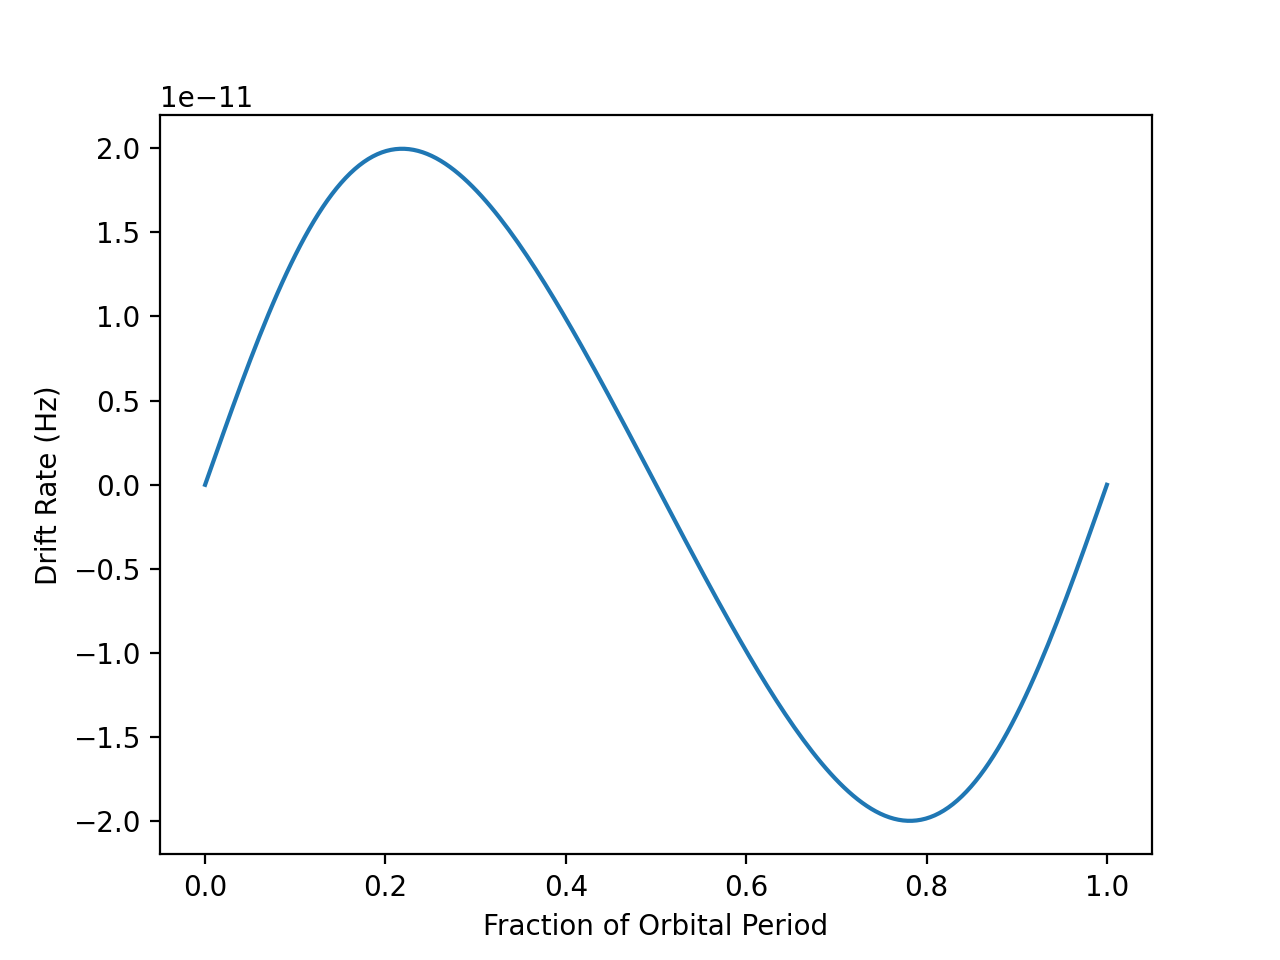

<IPython.core.display.Javascript object>


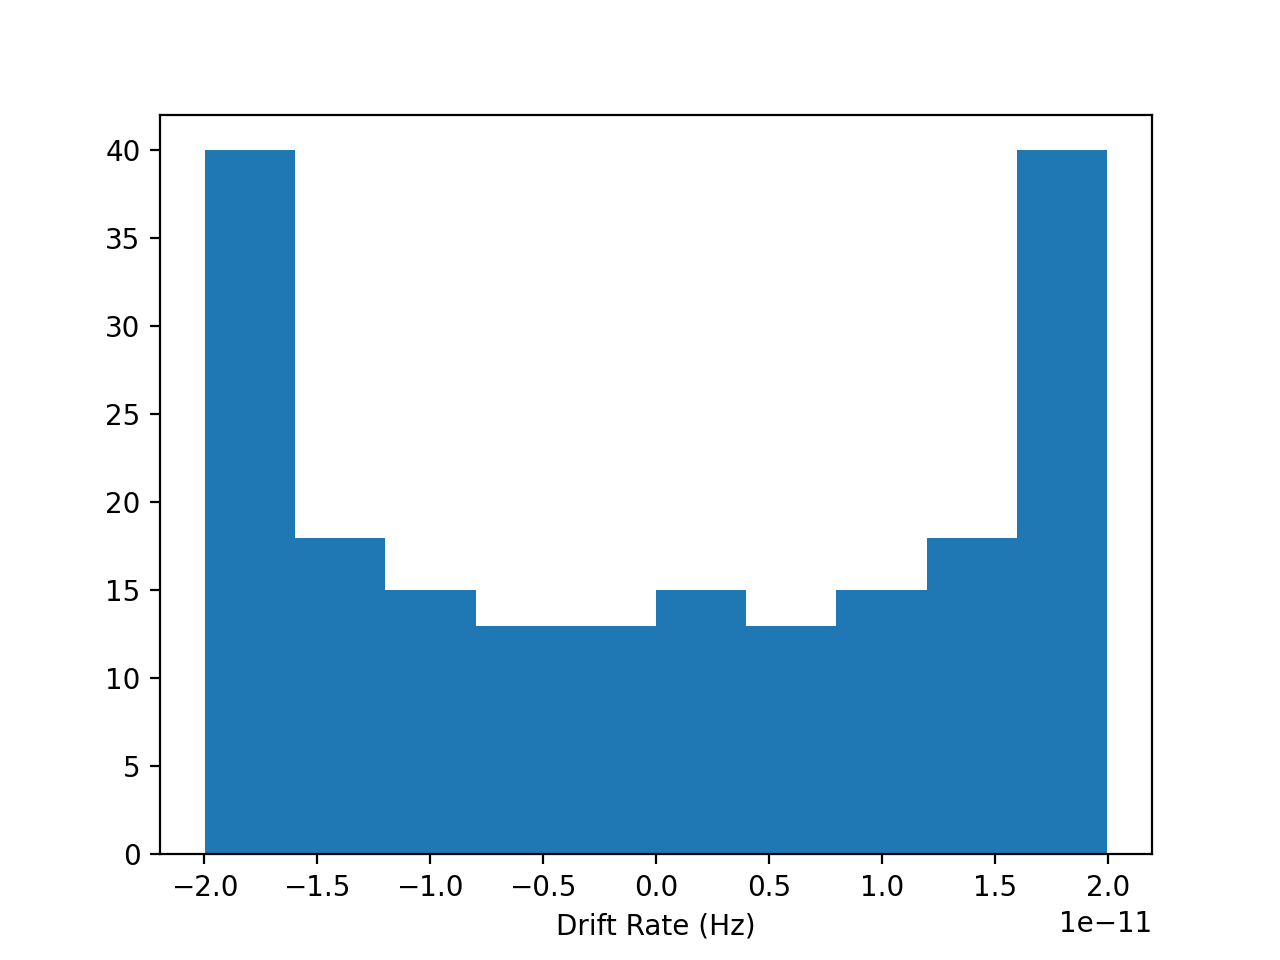

In [81]:
visualize_drift_rates(final_drift_rate_1, ke_1)

Hooray ! Everything is working. What's sad is that I didn't follow the directions ha

## "Main" Function
I want the next part to combine some of the earlier steps and return a position array and a drift rate array.

In [97]:
def position_and_drift_rate_array(semimajor, period, e, omega, i, w, num_timestep):
    ke = pyasl.KeplerEllipse(semimajor, period, e, Omega = omega,i = i,w = w)
    # Build the ellipse
    t = np.linspace(0, period, num_timestep)
    # Make a time axis
    pos = ke.xyzPos(t)
    radius = ke.radius(t)
    total_acc = G*stellar_mass/(radius* u.au)**2
    z_acceleration_array = []
    vector_to_earth = [0,0,1]
    for i in range(0, num_timestep):
        position_vector = ke.xyzPos(t)[i,:]
        radius = ke.radius(t)
        # vector from the origin (host star) to the point in the orbit
        z_magnitude = np.dot(vector_to_earth, position_vector) / radius[i]
        # normalized magnitude of the vector in the observer's direction - between -1 and 1
        z_acceleration_array.append((z_magnitude * total_acc[i]).value/c)
        # I removed the units from c in favor of adding in the per second at the end as arrays don't do too well with units
    return [pos, z_acceleration_array]

In [98]:
position_and_drift_rate_array_1 = position_and_drift_rate_array(1, 1, 0.05, 0, 90, 0, 200)
print(position_and_drift_rate_array_1)

[array([[ 9.50000000e-01,  0.00000000e+00,  0.00000000e+00],
       [ 9.49447760e-01,  2.03215267e-18,  3.31875716e-02],
       [ 9.47791778e-01,  4.06194301e-18,  6.63365635e-02],
       [ 9.45034266e-01,  6.08701267e-18,  9.94084609e-02],
       [ 9.41178908e-01,  8.10501126e-18,  1.32364879e-01],
       [ 9.36230847e-01,  1.01136002e-17,  1.65167626e-01],
       [ 9.30196675e-01,  1.21104569e-17,  1.97778771e-01],
       [ 9.23084419e-01,  1.40932782e-17,  2.30160699e-01],
       [ 9.14903520e-01,  1.60597843e-17,  2.62276181e-01],
       [ 9.05664812e-01,  1.80077227e-17,  2.94088429e-01],
       [ 8.95380502e-01,  1.99348715e-17,  3.25561159e-01],
       [ 8.84064132e-01,  2.18390432e-17,  3.56658642e-01],
       [ 8.71730560e-01,  2.37180877e-17,  3.87345767e-01],
       [ 8.58395919e-01,  2.55698959e-17,  4.17588090e-01],
       [ 8.44077584e-01,  2.73924028e-17,  4.47351886e-01],
       [ 8.28794137e-01,  2.91835904e-17,  4.76604200e-01],
       [ 8.12565320e-01,  3.09414906e-1

## Orbital Plot Function
I think the earlier function build_and_plot_ellipse will work for this one. 

## Line Plot Function
It's pretty disappointing that I didn't read directions and combined the two functions I was supposed to keep separate.

In [102]:
def line_plot(drift_rates, period):
    #Should I be able to write this one without using the period?
    t = np.linspace(0, period, len(drift_rates))
    plt.figure()
    plt.xlabel('Fraction of Orbital Period')
    plt.ylabel('Drift Rate (Hz)')
    plt.plot(t, drift_rates)
    plt.show()
    return
    

<IPython.core.display.Javascript object>


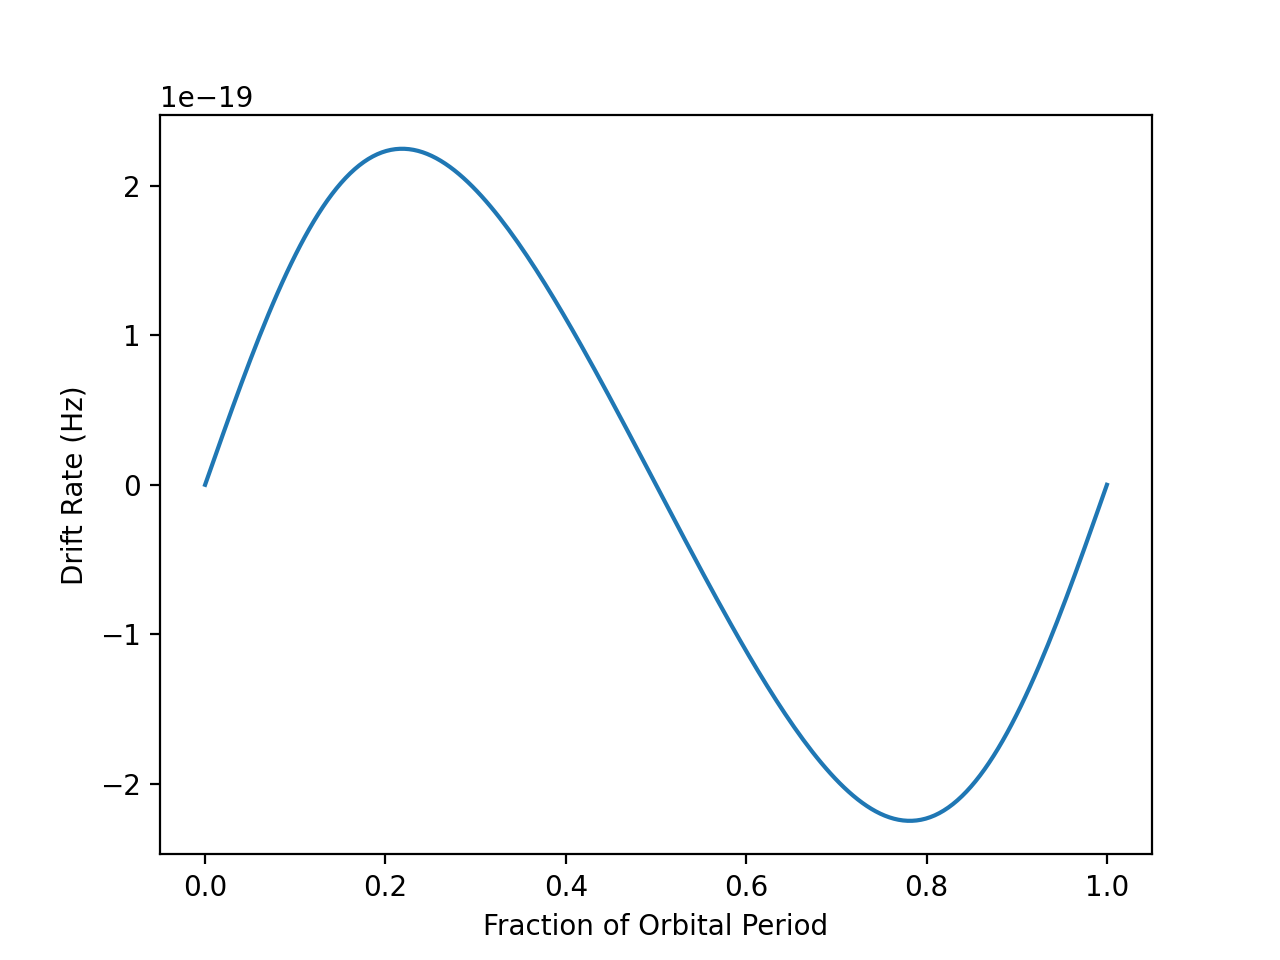

In [103]:
line_plot(position_and_drift_rate_array_1[1], 1)

## Histogram Function


In [104]:
def histogram(drift_rates):
    plt.figure()
    plt.hist(drift_rates)
    plt.xlabel('Drift Rate (Hz)')
    plt.show()
    return

<IPython.core.display.Javascript object>


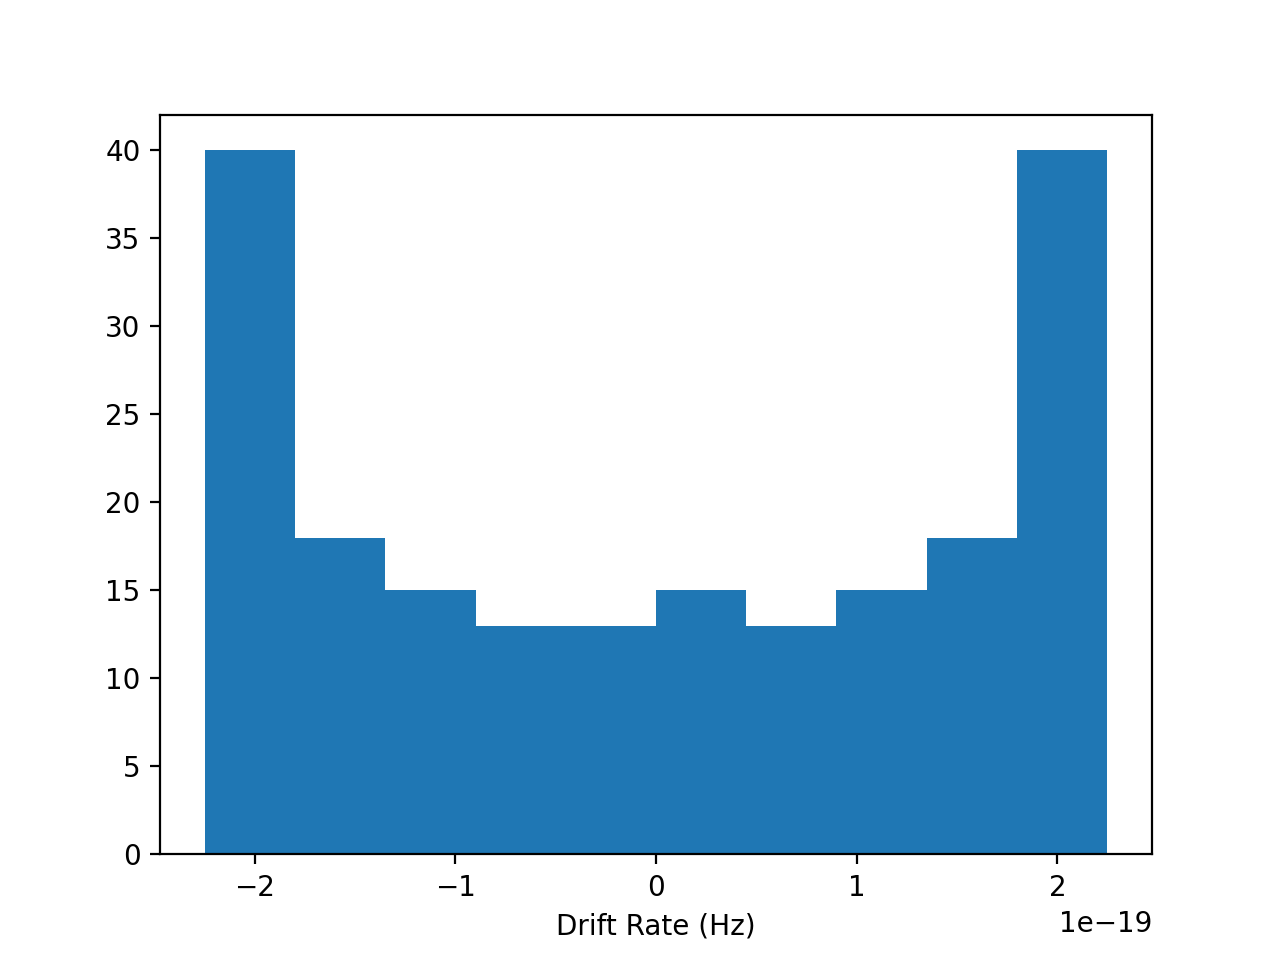

In [106]:
histogram(position_and_drift_rate_array_1[1])

## Testing Different Eccentricities

<IPython.core.display.Javascript object>


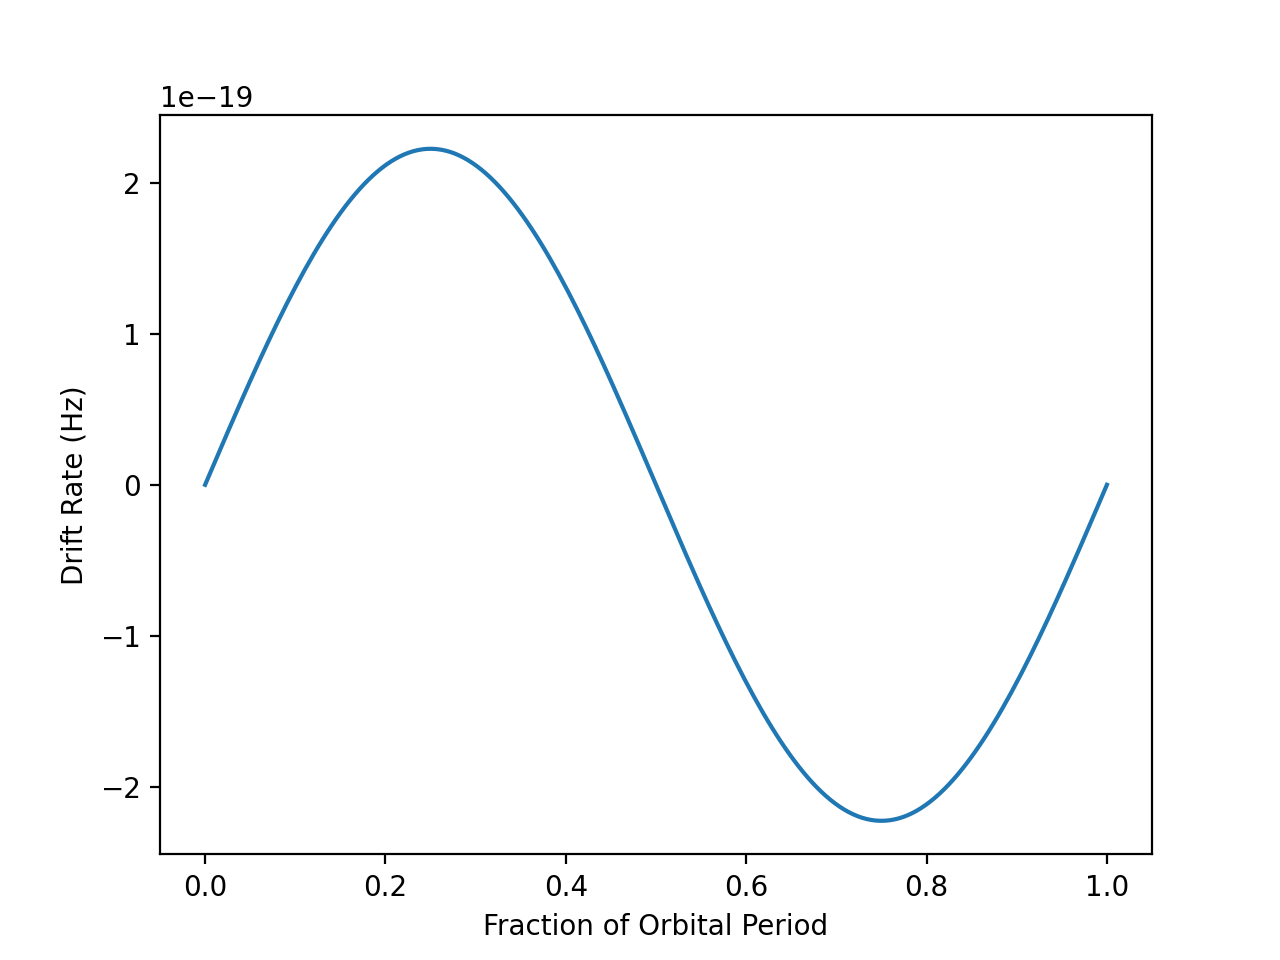

<IPython.core.display.Javascript object>


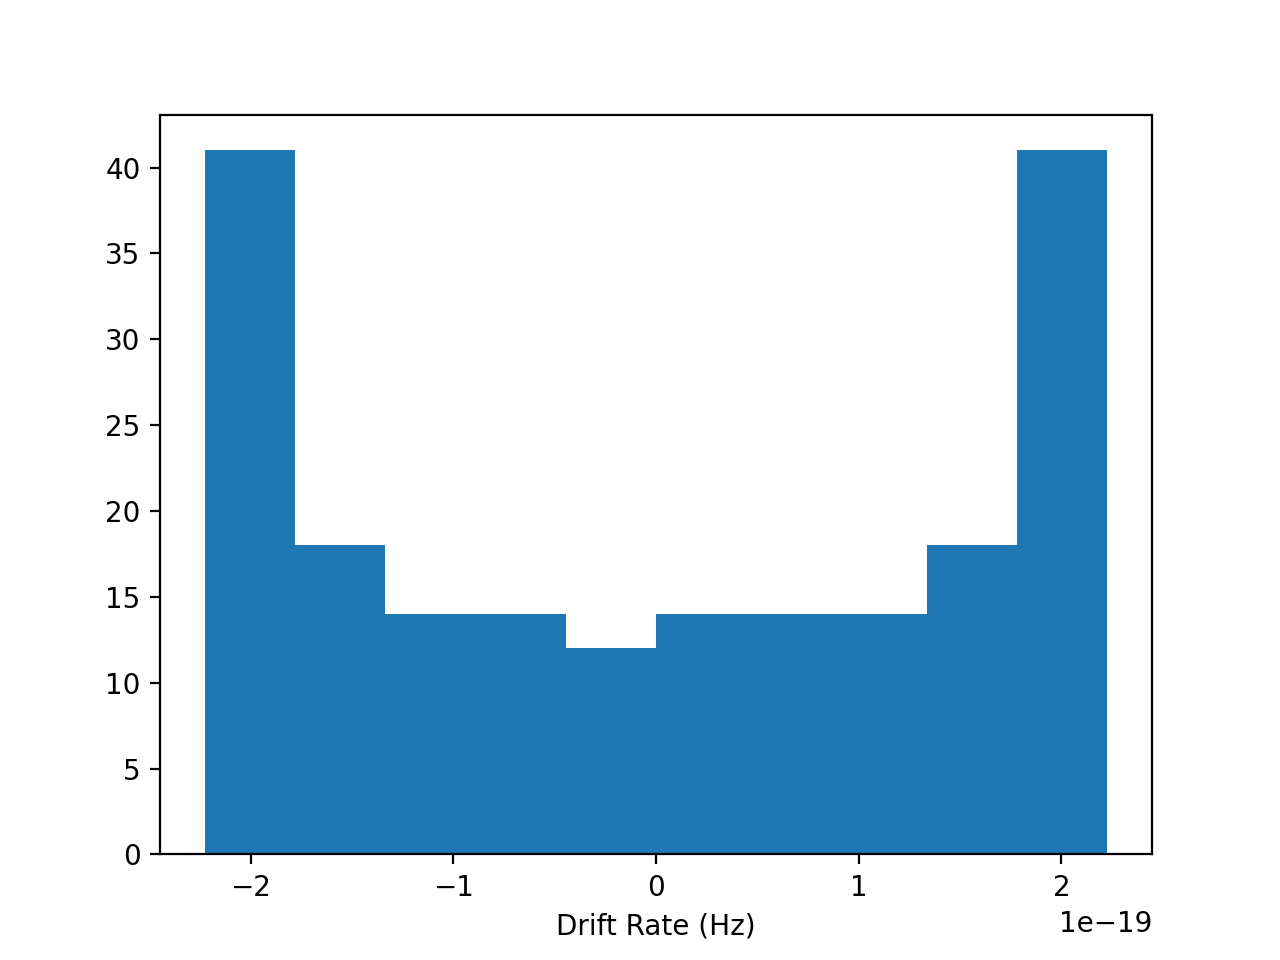

<IPython.core.display.Javascript object>


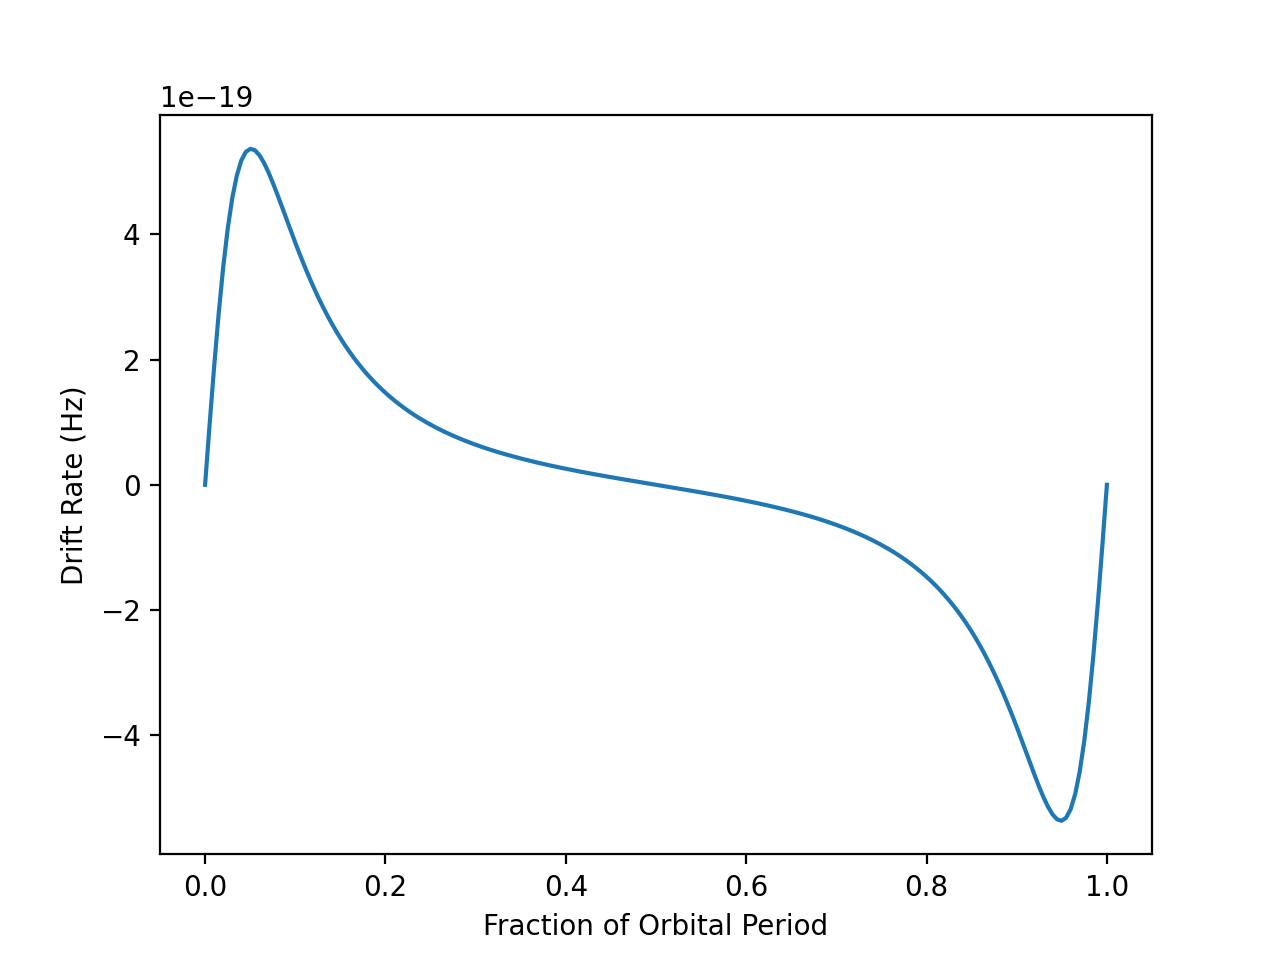

<IPython.core.display.Javascript object>


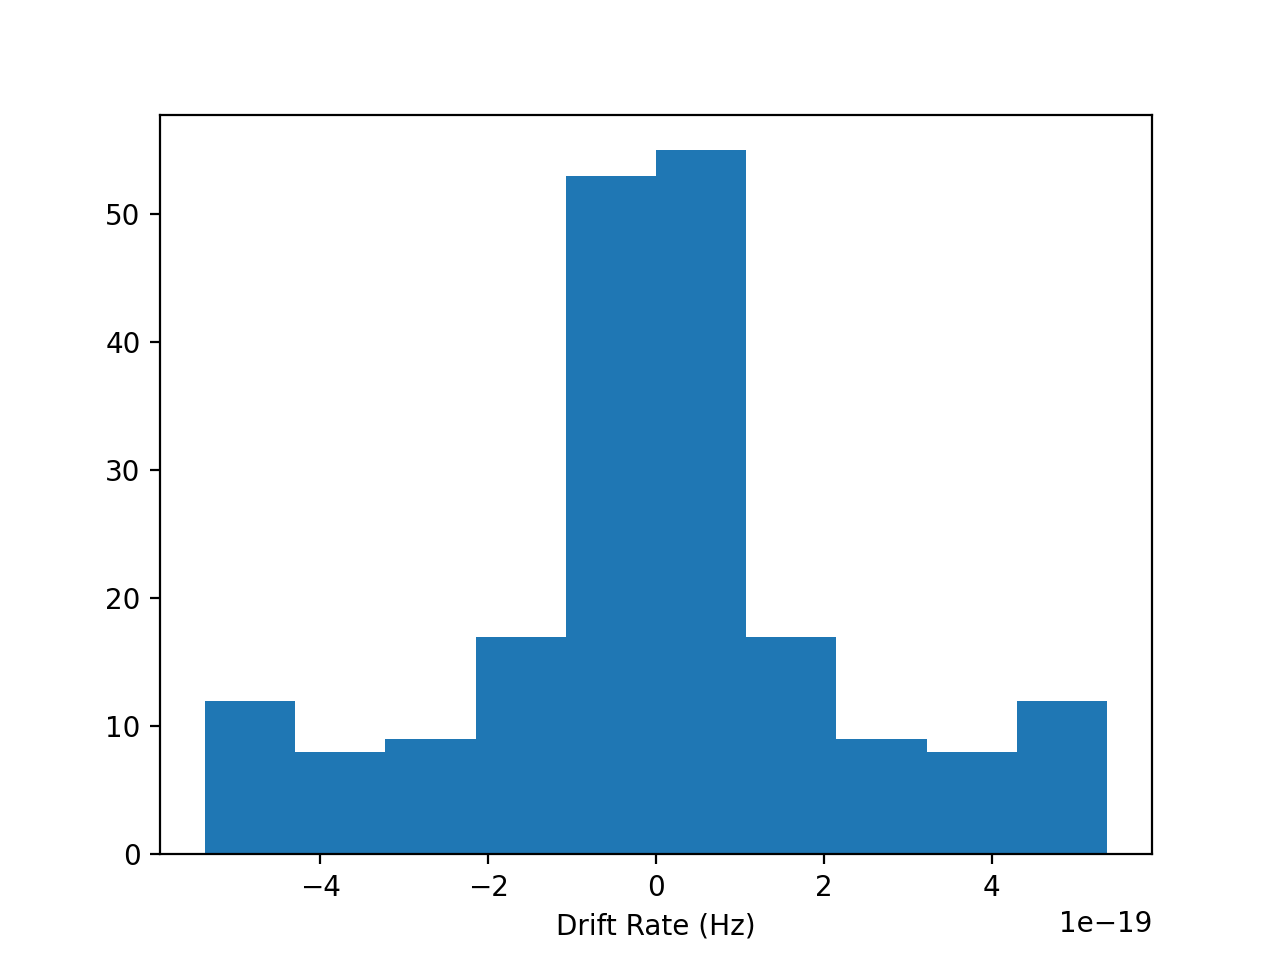

<IPython.core.display.Javascript object>


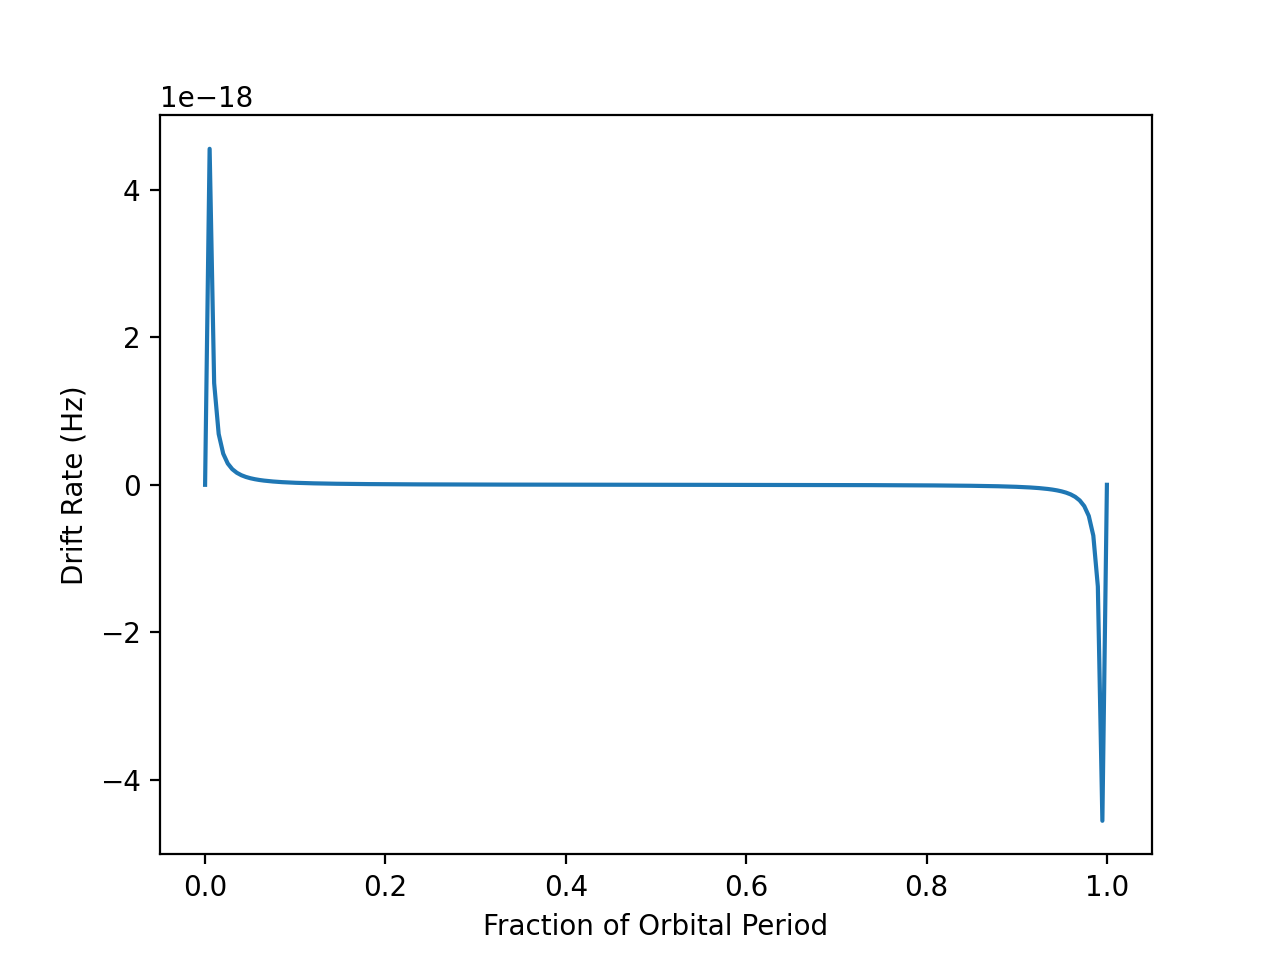

<IPython.core.display.Javascript object>


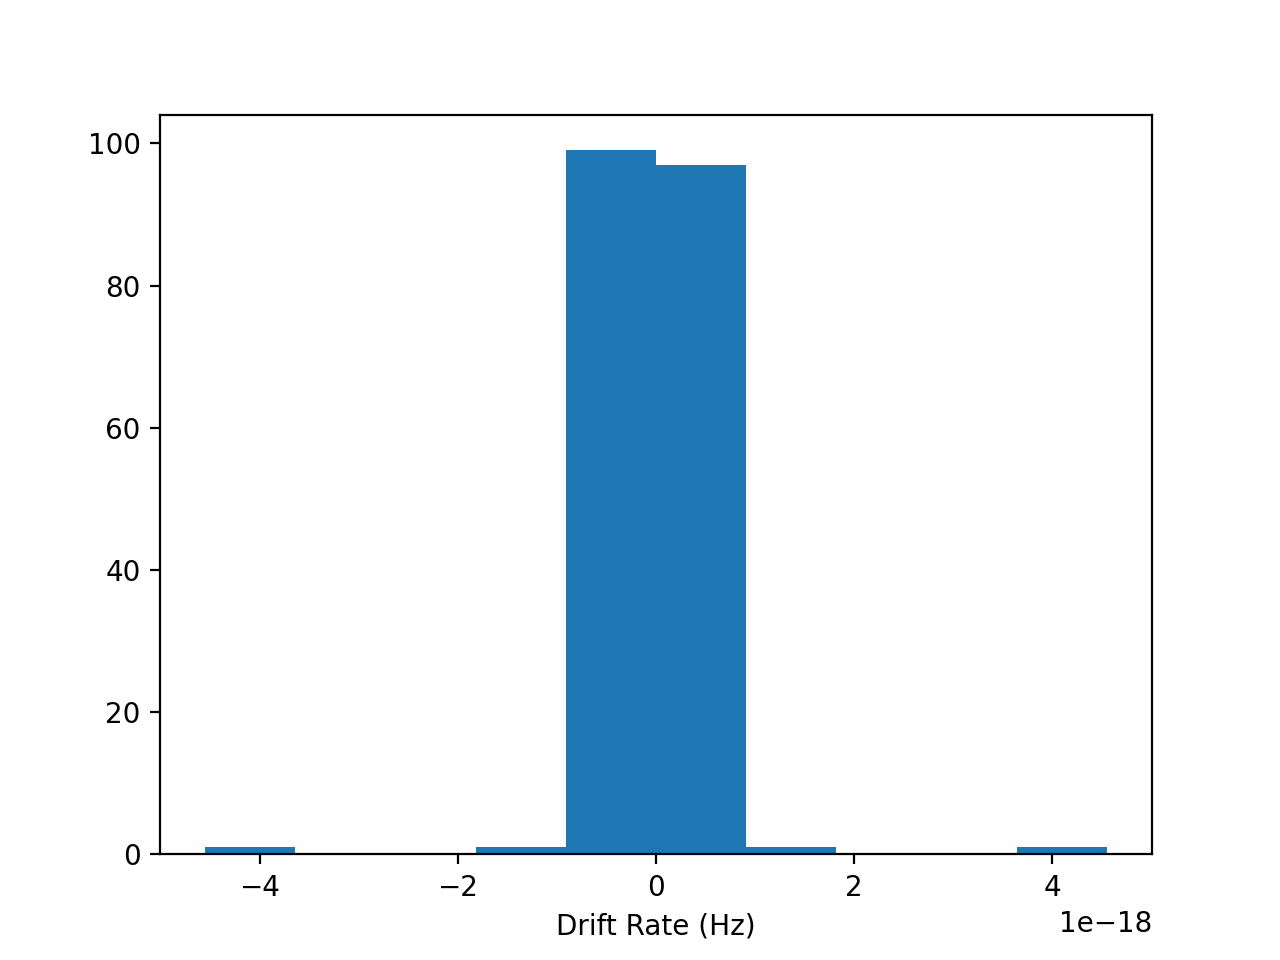

In [108]:
for e in [0, 0.5, 0.99]:
    pos_and_drift_rate = position_and_drift_rate_array(1, 1, e, 0, 90, 0, 200)
    line_plot(pos_and_drift_rate[1], 1)
    histogram(pos_and_drift_rate[1])